In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

In [121]:
def windows(sample_data, window_size):
    start = 0
    while start < sample_data.shape[1]:
        yield start, start + window_size
        start += (window_size)
        
def reshape_data(data, nb_features, num_features):
    
    import numpy as np
    
    X_r = np.zeros((len(data), nb_features, num_features))

    for i,(start,end) in zip(range(num_features),windows(data,nb_features)):

        X_r[:, :, i] = data[:, start:end]
    return(X_r)

In [64]:
train = pd.read_csv('Jan30_monthly_weather_df.csv')

In [65]:
yield_df = pd.read_csv('Field-level yield + metadata.csv')

In [66]:
features_2017 = list(train.filter(regex=('2017')).columns)

In [67]:
full_weather_col_list = train.columns

In [68]:
features_2014_2016 = full_weather_col_list.drop(features_2017)

In [69]:
train_2014_2016 = train[features_2014_2016]

In [70]:
train_2014_2016['fieldID_2017'] = train_2014_2016['field_season_index'] .apply(lambda x: x.split('_')[0])

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [94]:
train_2014_2016['fieldID_2017'] = train_2014_2016['fieldID_2017'].astype(int)

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [232]:
sample_y = pd.concat([yield_df['fieldID_2017'],yield_df['Unmask Tiff Yield'],yield_df['crop_2017']],axis=1)

In [233]:
sample_y['fieldID_2017'] = sample_y['fieldID_2017'].astype(int)

In [234]:
df_merge = pd.merge(sample_y,train_df, on= 'fieldID_2017')

In [235]:
MergeDat=train_2014_2016.merge(sample_y,how="left")

In [236]:
df1 = MergeDat.dropna(subset=['Unmask Tiff Yield'])
df1.shape

(250, 19264)

In [237]:
y = df1['Unmask Tiff Yield']
X_sample = df1.drop(['Unmask Tiff Yield','crop_2017','fieldID_2017','field_season_index'],axis = 1)

In [239]:
X_sample_nona = X_sample.drop(X_sample.columns[432:468],axis = 1)

In [240]:
pd.isna(X_sample_nona).any().sum()

0

In [337]:
def train_test_split(sample_data, valsize = 0.05, random_state = 42):
    
    import pandas as pd
    from sklearn.model_selection import train_test_split

    _, _, train_idx, val_idx = train_test_split(sample_data, sample_data.index, test_size=valsize, random_state=random_state)
    
    sample_data.ix[train_idx,'split'] = 'Train'
    sample_data.ix[val_idx,'split'] = 'Validation'
    
    print(sample_data['split'].value_counts())
    
    return(sample_data)

df1 = train_test_split(df1, valsize = 0.25, random_state = 10)

Train         187
Validation     63
Name: split, dtype: int64


C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [338]:
from sklearn.preprocessing import StandardScaler
x_values = X_sample_nona.values

scaler = StandardScaler().fit(x_values)
scaled_x = scaler.transform(x_values)

In [339]:
X_train = scaled_x[df1.split=='Train']
X_val = scaled_x[df1.split=='Validation']

Y_train = y[df1.split=='Train']
Y_val = y[df1.split=='Validation']

In [340]:
int(X_train.shape[1]/36)

534

In [341]:
X_train_r = reshape_data(X_train, 36, int(X_train.shape[1]/36))
print(X_train_r.shape)
X_val_r = reshape_data(X_val,36, int(X_val.shape[1]/36))
print(X_val_r.shape)

(187, 36, 534)
(63, 36, 534)


In [342]:
model = Sequential()
model.add(Convolution1D(nb_filter=10, filter_length=2, input_shape=(36, 534)))
# model.add(Activation('sigmoid'))
model.add(Flatten())
model.add(Dropout(0.4))
# model.add(Dense(2048, activation='sigmoid'))
# model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(1,kernel_initializer='normal'))
model.add(Activation('linear'))

sgd = SGD(lr=0.0005, nesterov=True, decay=1e-6, momentum=0.9)
model.compile(loss='mean_absolute_error',optimizer=sgd)

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(36, 534), filters=10, kernel_size=2)`
  


In [343]:
model.fit(X_train_r, Y_train, nb_epoch=50, validation_data=(X_val_r, Y_val), batch_size=16)


C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\keras\models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 187 samples, validate on 63 samples
Epoch 1/50
187/187 [==============================] - 1s 4ms/step - loss: 2477.8689 - val_loss: 2518.8729
Epoch 2/50
187/187 [==============================] - 0s 936us/step - loss: 2477.6670 - val_loss: 2519.0447
Epoch 3/50
187/187 [==============================] - 0s 842us/step - loss: 2477.5434 - val_loss: 2519.1593
Epoch 4/50
187/187 [==============================] - 0s 783us/step - loss: 2477.4529 - val_loss: 2519.3234
Epoch 5/50
187/187 [==============================] - 0s 853us/step - loss: 2476.9961 - val_loss: 2519.5215
Epoch 6/50
187/187 [==============================] - 0s 855us/step - loss: 2476.4374 - val_loss: 2519.5185
Epoch 7/50
187/187 [==============================] - 0s 815us/step - loss: 2475.9392 - val_loss: 2519.3595
Epoch 8/50
187/187 [==============================] - 0s 890us/step - loss: 2474.8293 - val_loss: 2519.2986
Epoch 9/50
187/187 [==============================] - 0s 861us/step - loss: 2472.4157 - val_l

In [344]:
crop_2017_label = df1['crop_2017']

crop_2017_label_dummy = pd.get_dummies(df1['crop_2017'])
crop_label_train = crop_2017_label_dummy[df1.split == "Train"]
crop_label_val = crop_2017_label_dummy[df1.split == "Validation"]

In [345]:
X_all  = reshape_data(scaled_x, 36, 534)

In [365]:
ypred = model.predict(X_all)
ypred = ypred.flatten()

In [202]:
def abline(slope, intercept):
    '''
    DESC: Plot a line from slope and intercept
    INPUT: slope(float), intercept(float)
    -----
    OUTPUT: matplotlib plot with plotted line of desired slope and intercept
    '''
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', c='b', label='Perfect Predictions')

def line_of_best_fit(x, y,ci, label,c):
    '''
    DESC: Plot a line of best fit from scatter plot
    INPUT: x-coordinates(list/array), y-coordinates(list/array), confidence-interval(float), label(str)
    -----
    OUTPUT: seaborn plot with plotted line of best fit with confidence interval and equation for line of best fit
    '''
    import seaborn as sns
    sns.regplot(x, y, fit_reg=True, scatter=True, label=label, ci = ci,color=c)
    return np.polynomial.polynomial.polyfit(x, y, 1)

In [354]:
def actual_v_predictions_plot(actual, preds, title, metric, ci, pos3=None, color='orange',label_dummies=None, save=False, savename = None):
    '''
    DESC: Creates and acutal v.s. predictions plot to evaluate regressions
    INPUT: actual(list/array), preds(list/array), title(str), ci(float), pos1(tuple), pos2(tuple), save(bool)
    -----
    OUTPUT: matplotlib plot with prefect fit, line of best fit equation and plot, scatter plot of actual vs predicted values and MAPE
    '''
    plt.xlim(0,10000)
    plt.ylim(0,10000)
    best_fit_eq= line_of_best_fit(actual, preds, ci = ci, label='Line of Best Fit with {}% CI'.format(ci), c=color)
    if isinstance(label_dummies, pd.DataFrame):
        labels = label_dummies.idxmax(axis=1)
        df = pd.DataFrame({'Actual':actual.tolist(), 'Predictions':list(preds),'Labels':labels})
        scatter_plot2d(df, 'Actual', 'Predictions', by='Labels')
    if isinstance(label_dummies, pd.Series):
        df = pd.DataFrame({'Actual':actual.tolist(), 'Predictions':list(preds),'Labels':label_dummies})
        scatter_plot2d(df, 'Actual', 'Predictions', by='Labels')
    abline(1,0)
    # MAE, RMSE, MAPE = regression_evaluation(df['Actual'].values, df['Predictions'].values)
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.title(title)
    plt.legend()
    plt.text(1000,8300,s='y = {}x + {}'.format(round(best_fit_eq[1],2), round(best_fit_eq[0],2)))
    if metric:
        plt.text(1000,7800, s='{}={}'.format(metric[0], round(metric[1],2)))
    if pos3:
        plt.text(pos3[0],pos3[1],'Canola = Red\nLentil = Green\nDurum = Blue\nHard Wheat = Purple')
    plt.rcParams.update({'font.size': 10, "figure.figsize":[6,6]})
    plt.tight_layout()
    if save:
        plt.savefig('./plot/'+savename+'.jpg')
    plt.show()
    print('Line of Best Fit: \t\t y = {}x + {}'. format(best_fit_eq[1], best_fit_eq[0]))
    
def histogram2d(actual, predictions):
    plt.hist2d(actual, predictions)
    plt.colorbar()
    plt.title('2D Histogram Actual v.s. Predicted Yield', fontsize=16)
    plt.xlabel('Predicted Yield', fontsize=16)
    plt.ylabel('Actual Yield', fontsize=16)
    plt.tight_layout()
    plt.savefig('hist2d')
    plt.show()
    
def predicted_actual_dist(actual, predictions, bins, save=False):
    plt.figure(figsize=(7,7))
    bins = np.linspace(0, 9000, bins)
    plt.hist(predictions, bins=bins, alpha=0.5, label='Predicted Yield')
    plt.hist(actual, bins=bins, color='g', alpha =0.5, label='Actual Yield')
    plt.xlabel('Yield', fontsize=16)
    plt.ylabel('Counts', fontsize=16)
    plt.legend(loc='best')
    plt.title('Distribution of Yield Predictions', fontsize=16)
    plt.tight_layout()
    if save:
        plt.savefig('Distribution of Yield Predictions.jpg')
    plt.show()
    
def scatter_plot2d(df,col1,col2,by=False,figsize=(8,6),label=['Canola','Durum','Lentil','Hard Wheat'],vmin=0,vmax=10000,xlabel=None,
                  ylabel=None,title=None,save=False):

    '''
    DESC:
            Plot 2d histogram colored by group column
    INPUT:
            df(pd.DataFrame):           Target dataframe
            co11(str):                  First target column
            col2(str):                  Second target column
            by(str):                    group column
            label(list):                legend labels
            vmin(int):                  min value for xlim/ylim
            vmax(int):                  max value for xlim/ymin

    -----
    OUTPUT: matplotlib 2d scatter plot with perfect matching line
    '''
    if by:
        num_unique = df[by].nunique()
        unique_value = sorted(df[by].unique())
        cmap = plt.cm.get_cmap('hsv',num_unique+1)

        colors=[]
        for i in range(num_unique):
            colors.append(cmap(i))

        for value,c in zip(unique_value,colors):
            print (c,value)
            plt.scatter(df.loc[df[by]==value][col1].values,df.loc[df[by]==value][col2].values,
                c=c,alpha=0.8,edgecolors = 'black')

        plt.xlim(vmin,vmax)
        plt.ylim(vmin,vmax)


        #plt.xticks(np.arange(1000,6000,1000),fontsize=12)
        #plt.yticks(np.arange(1000,6000,1000),fontsize=12)

        plt.title(title,fontsize=16)
        plt.xlabel(xlabel,fontsize=16)
        plt.ylabel(ylabel,fontsize=16)

        if save:
            plt.savefig(save)




In [372]:
ypred = model.predict(X_all)
ypred = ypred.flatten()

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# rmse
print("rmse = ", sqrt(mean_squared_error(y, ypred)))

# MAE
print('mae =', mean_absolute_error(y, ypred))

# MAPE
print('mape =', mean_absolute_percentage_error(y, ypred))

rmse =  921.2943748506353
mae = 675.2880012234086
mape = 30.61773081839699


(1.0, 0.0, 0.0, 1.0) 28.0
(0.5234360234360234, 1.0, 0.0, 1.0) 47.0
(0.0, 1.0, 0.9531223422015865, 1.0) 80.0
(0.4296860234360234, 0.0, 1.0, 1.0) 173.0


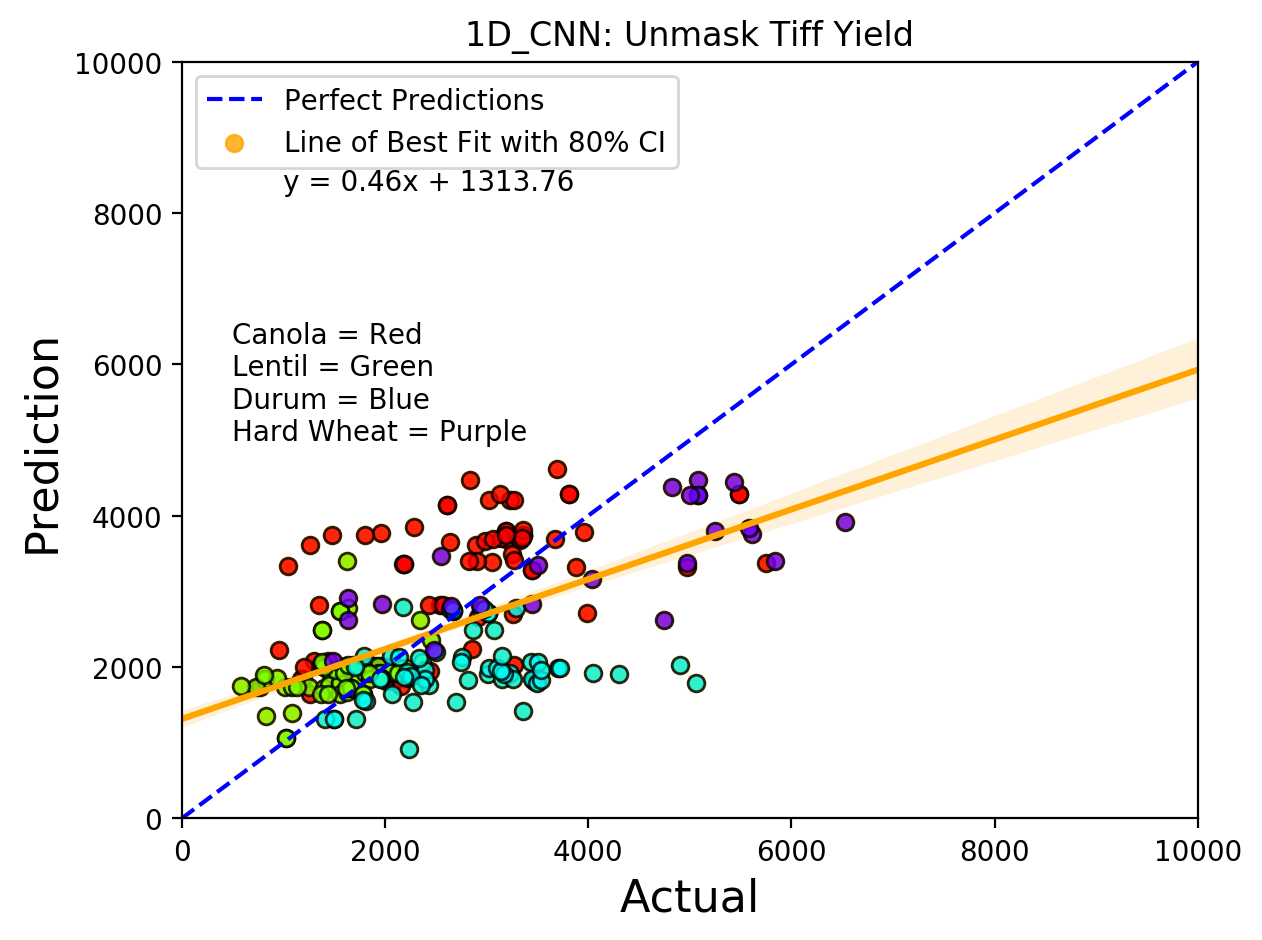

Line of Best Fit: 		 y = 0.46166347418200543x + 1313.7641006591573


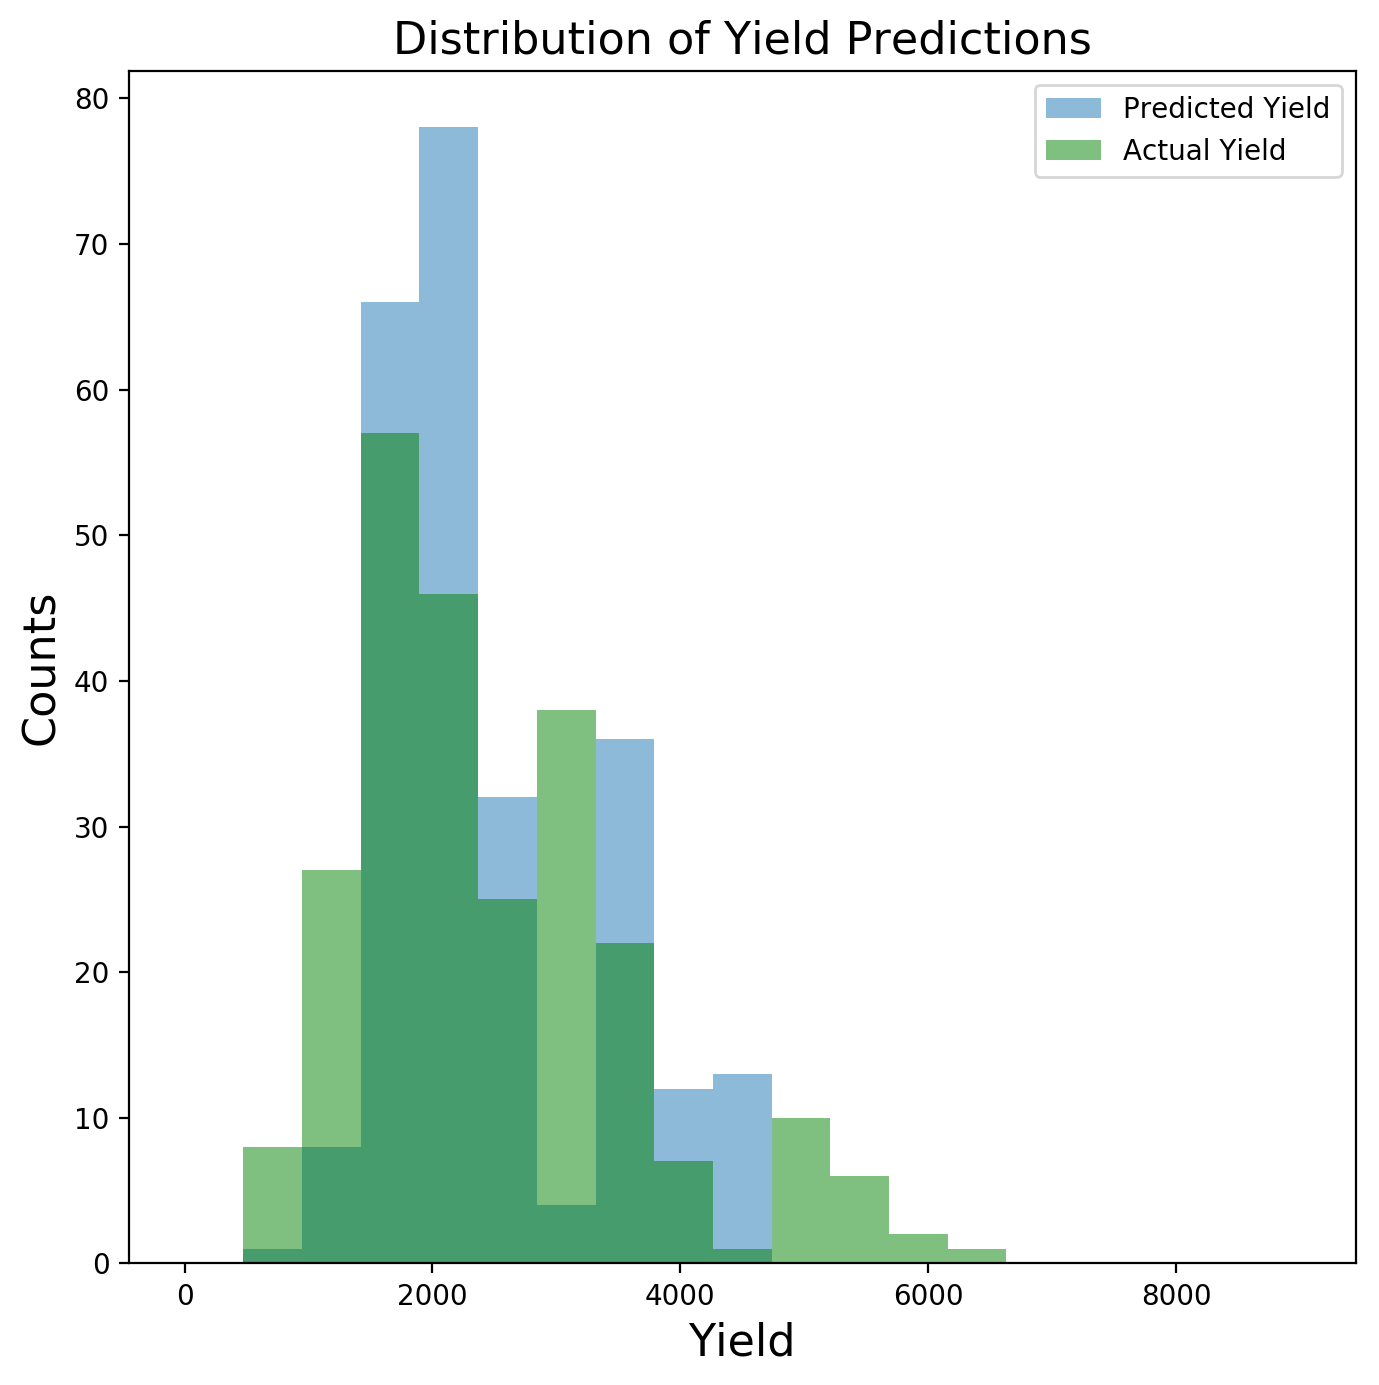

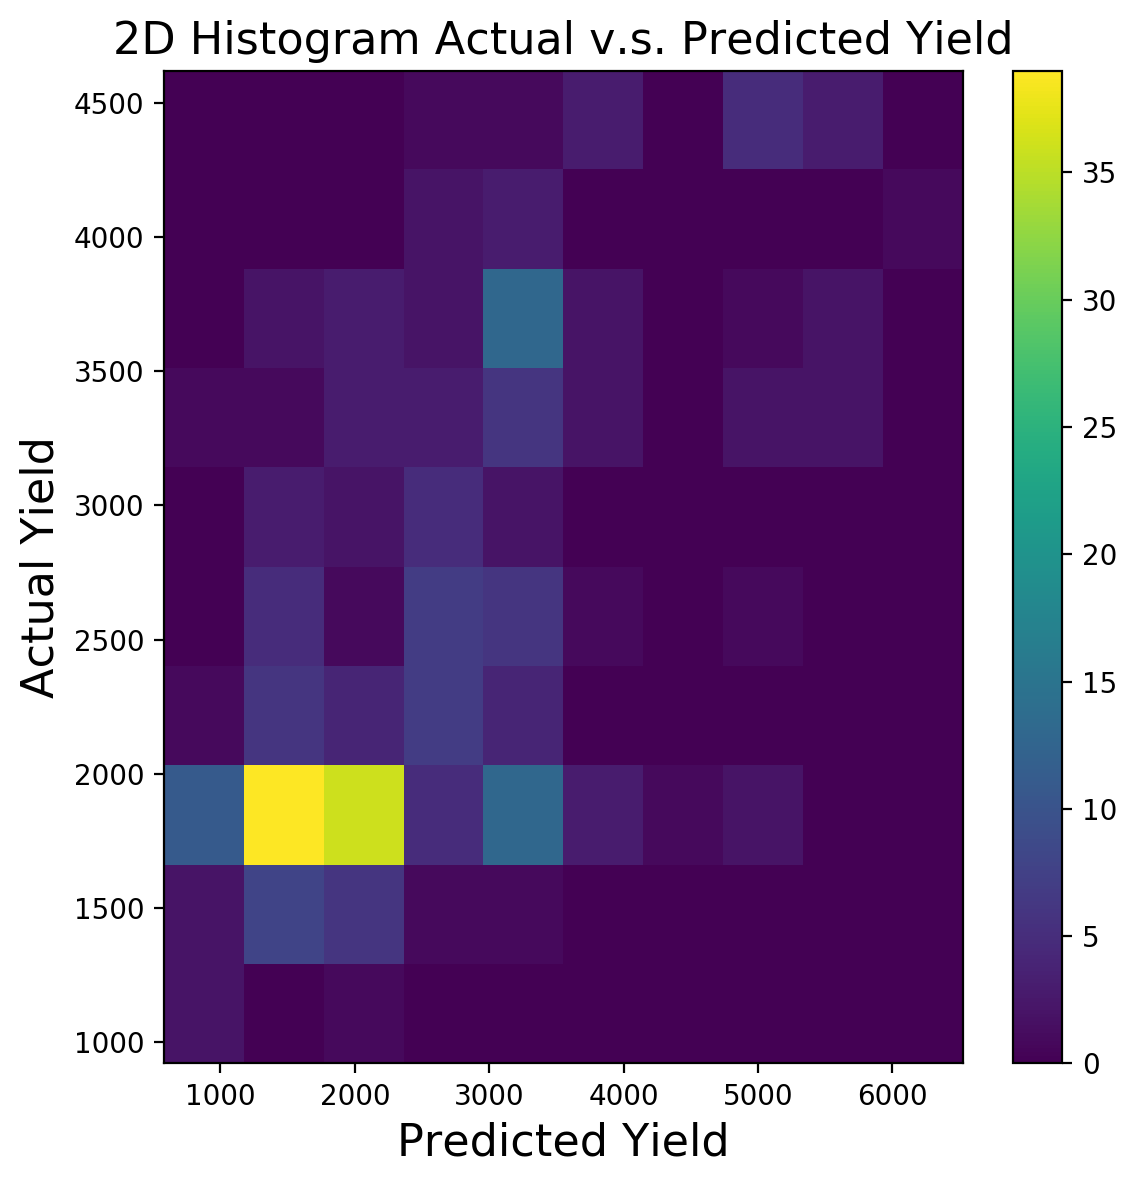

In [373]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')
actual_v_predictions_plot(actual = y, preds=ypred, title = "1D_CNN: Unmask Tiff Yield", pos3= [500,5000], metric = None, ci = 80, color='orange',label_dummies=crop_2017_label_dummy, save=True, savename = "1dcnn_all")
predicted_actual_dist(y, ypred.flatten(), bins = 20, save = True)
histogram2d(y, ypred)


In [374]:
ypred = model.predict(X_val_r)
ypred = ypred.flatten()

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# rmse
print("rmse = ", sqrt(mean_squared_error(Y_val, ypred)))

# MAE
print('mae =', mean_absolute_error(Y_val, ypred))

# MAPE
print('mape =', mean_absolute_percentage_error(Y_val, ypred))

rmse =  1003.0436717793749
mae = 759.1875340850644
mape = 31.60607508241752


(1.0, 0.0, 0.0, 1.0) 28.0
(0.5234360234360234, 1.0, 0.0, 1.0) 47.0
(0.0, 1.0, 0.9531223422015865, 1.0) 80.0
(0.4296860234360234, 0.0, 1.0, 1.0) 173.0


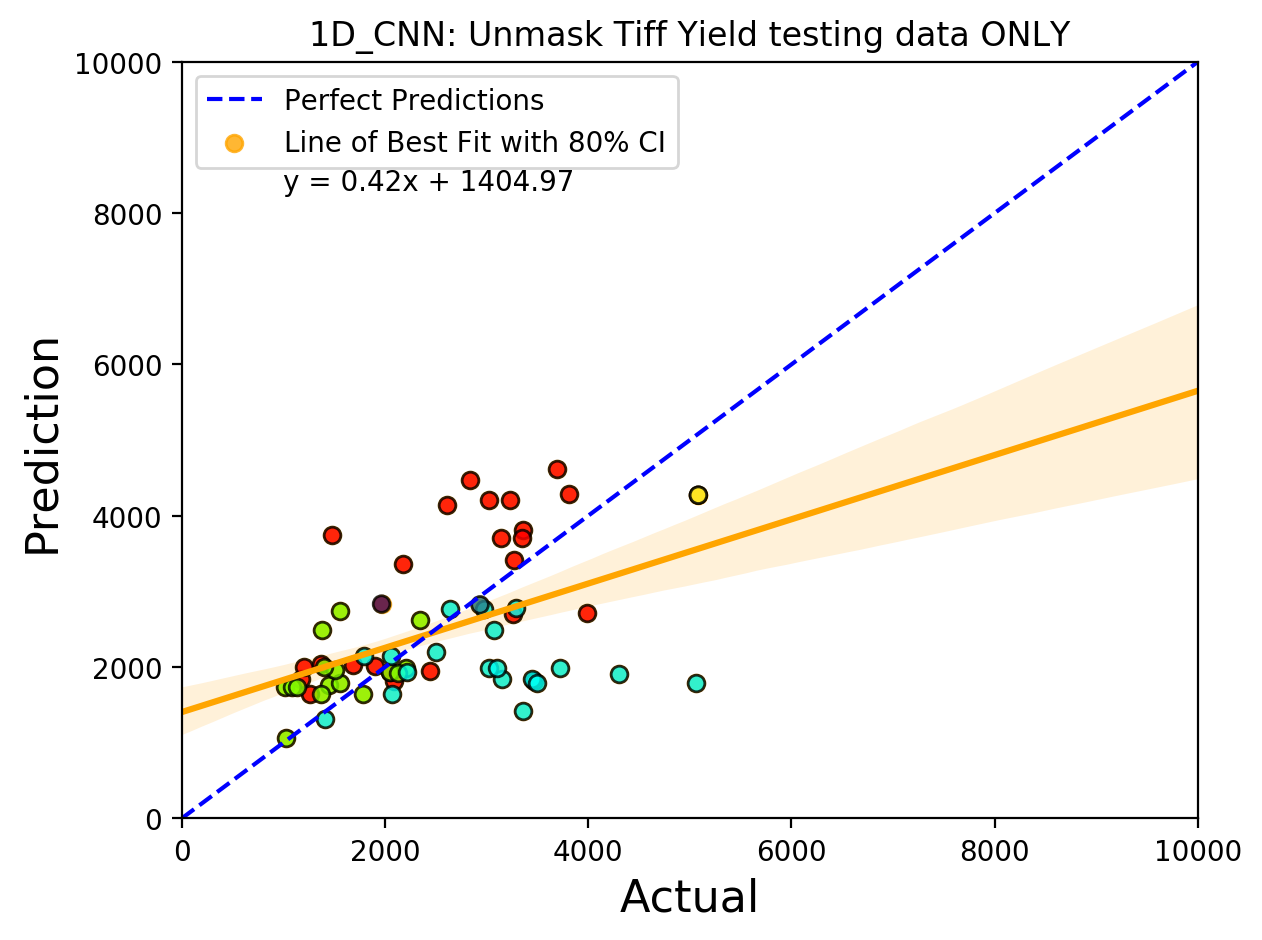

Line of Best Fit: 		 y = 0.4246833853221511x + 1404.9656172132354


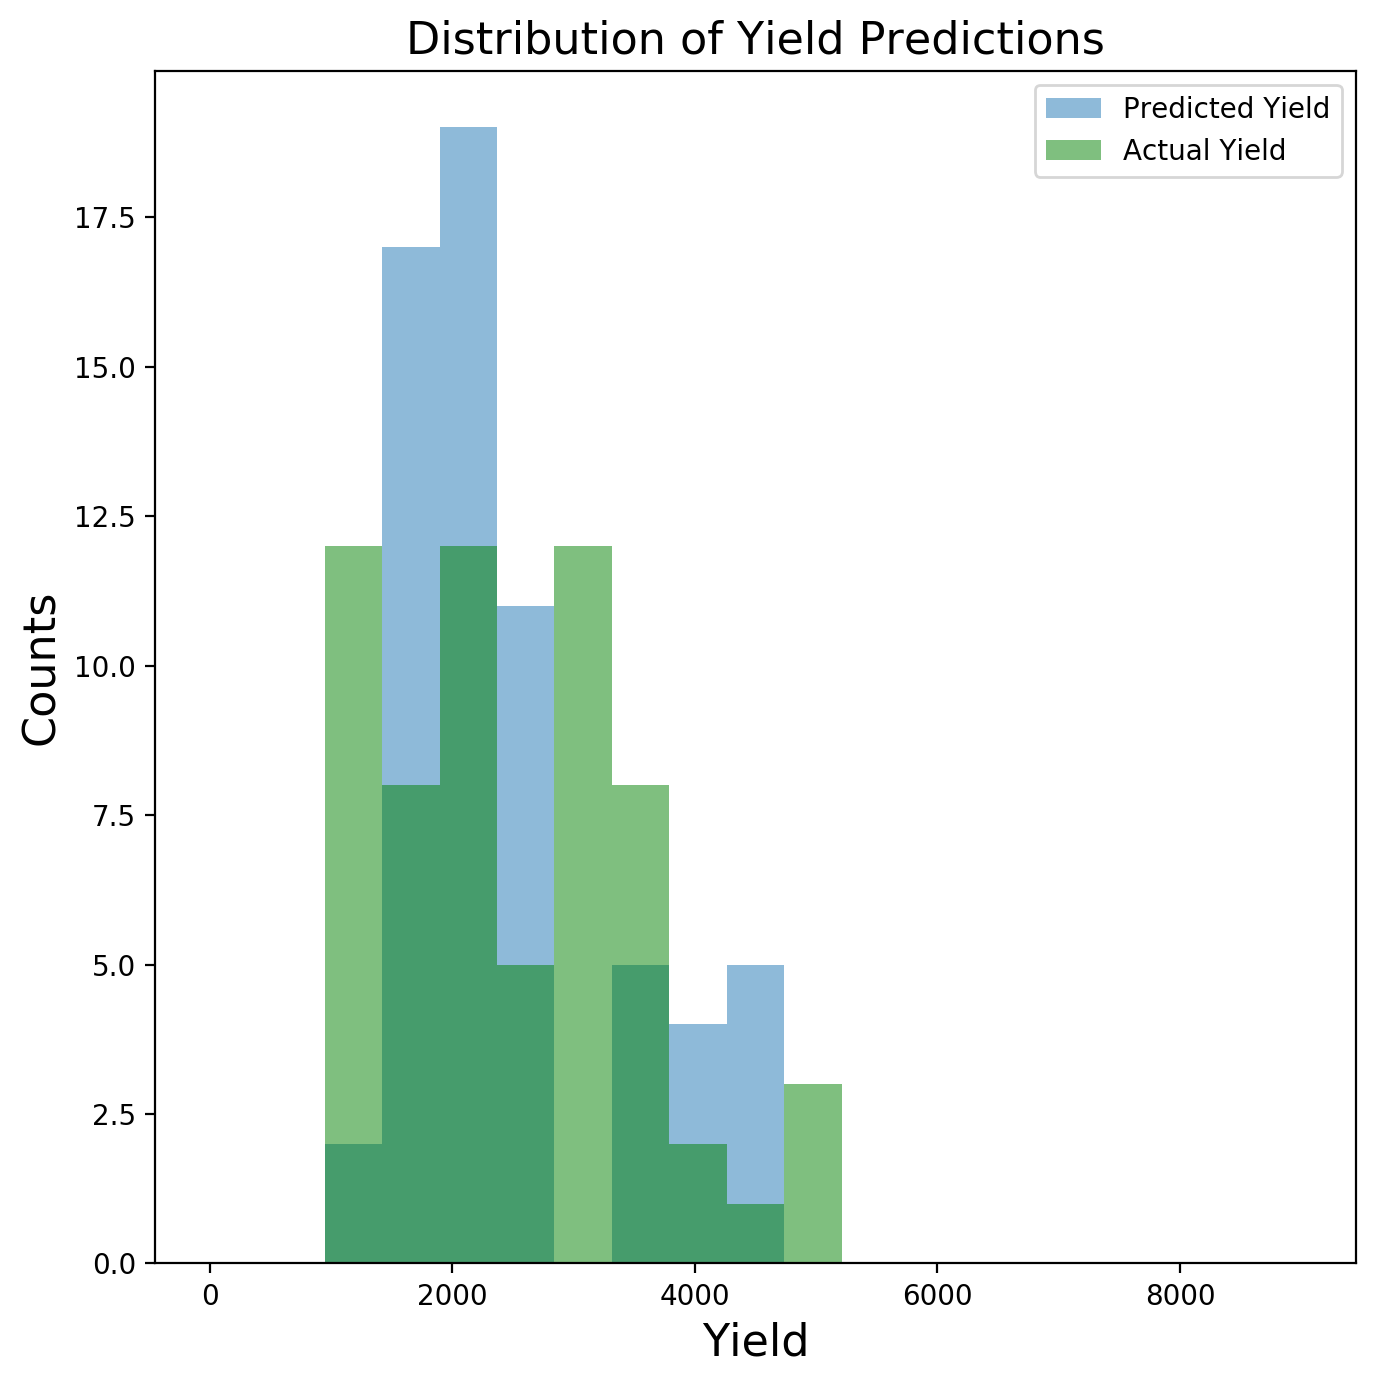

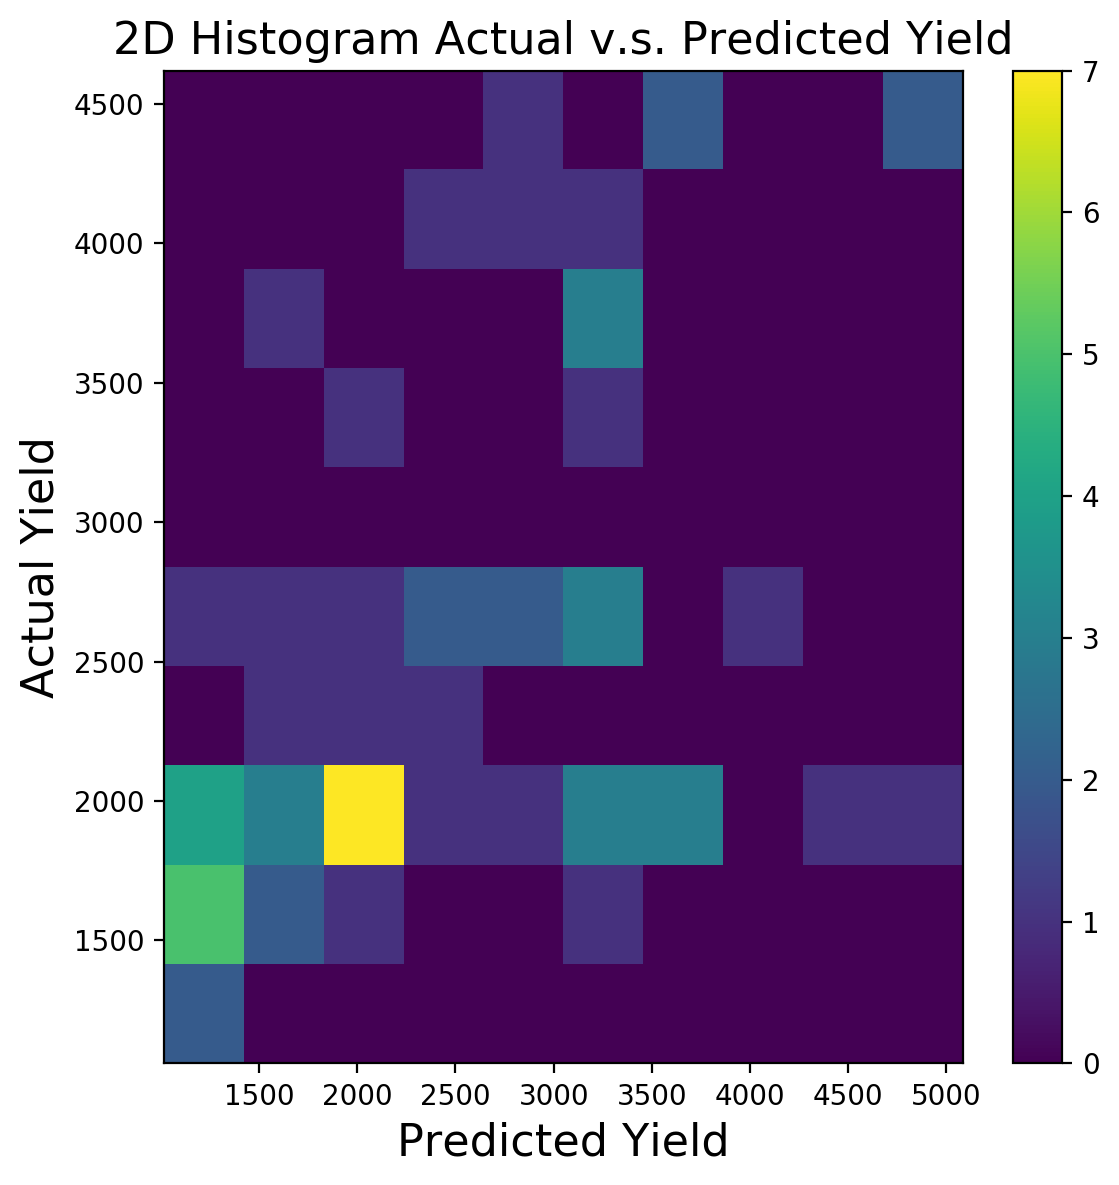

In [375]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')
actual_v_predictions_plot(actual = Y_val, preds=ypred, title = "1D_CNN: Unmask Tiff Yield testing data ONLY", metric = None, ci = 80, pos3=None, color='orange',label_dummies=crop_label_val, save=True, savename = "1dcnn_Val")
predicted_actual_dist(Y_val, ypred.flatten(), bins = 20, save = True)
histogram2d(Y_val, ypred)

In [376]:
ypred = model.predict(X_train_r)
ypred = ypred.flatten()

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# rmse
print("rmse = ", sqrt(mean_squared_error(Y_train, ypred)))

# MAE
print('mae =', mean_absolute_error(Y_train, ypred))

# MAPE
print('mape =', mean_absolute_percentage_error(Y_train, ypred))

rmse =  892.067672700243
mae = 647.0223832004979
mape = 30.2847592214275


(1.0, 0.0, 0.0, 1.0) 28.0
(0.5234360234360234, 1.0, 0.0, 1.0) 47.0
(0.0, 1.0, 0.9531223422015865, 1.0) 80.0
(0.4296860234360234, 0.0, 1.0, 1.0) 173.0


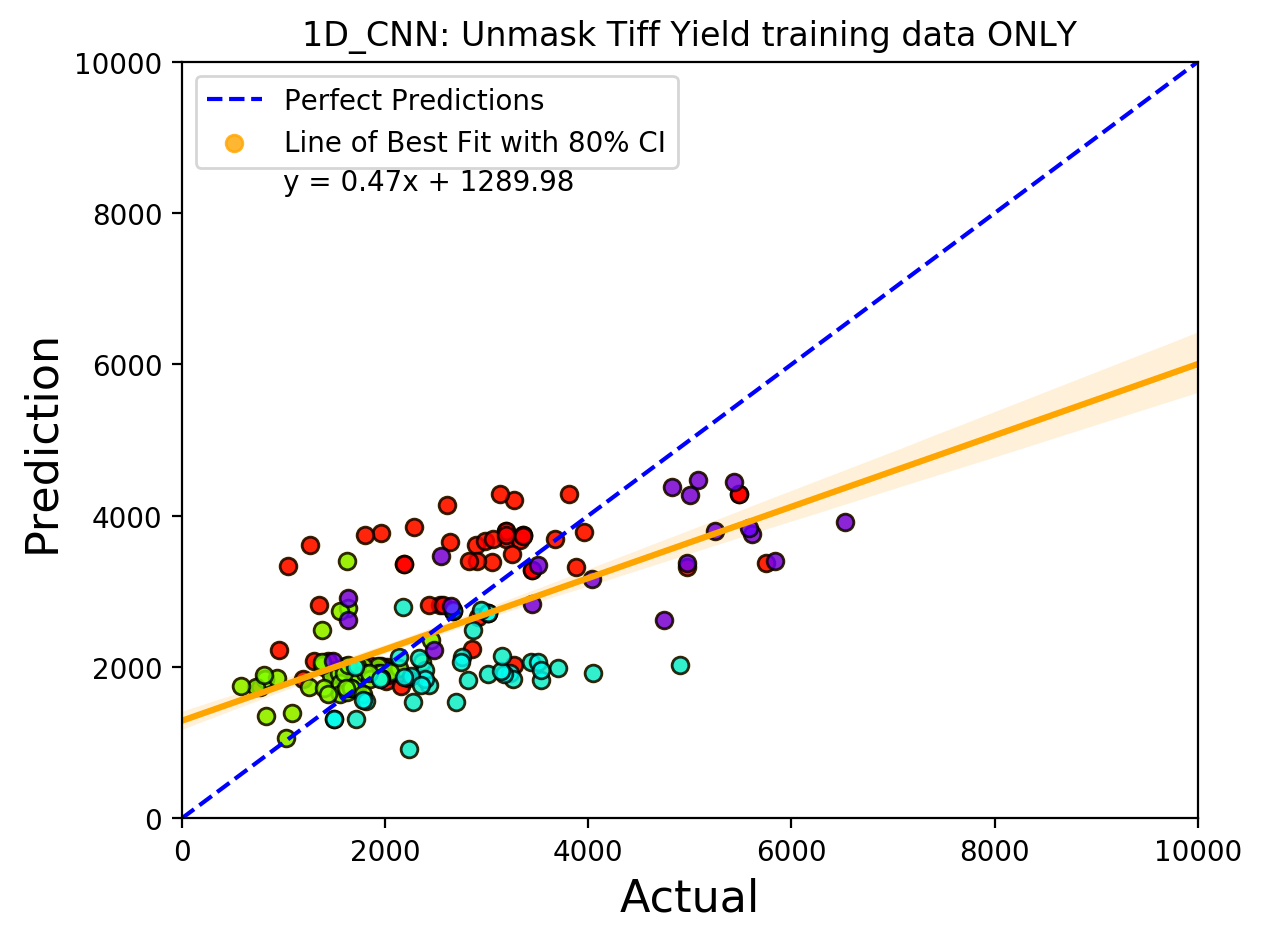

Line of Best Fit: 		 y = 0.4715280922733107x + 1289.9768045576177


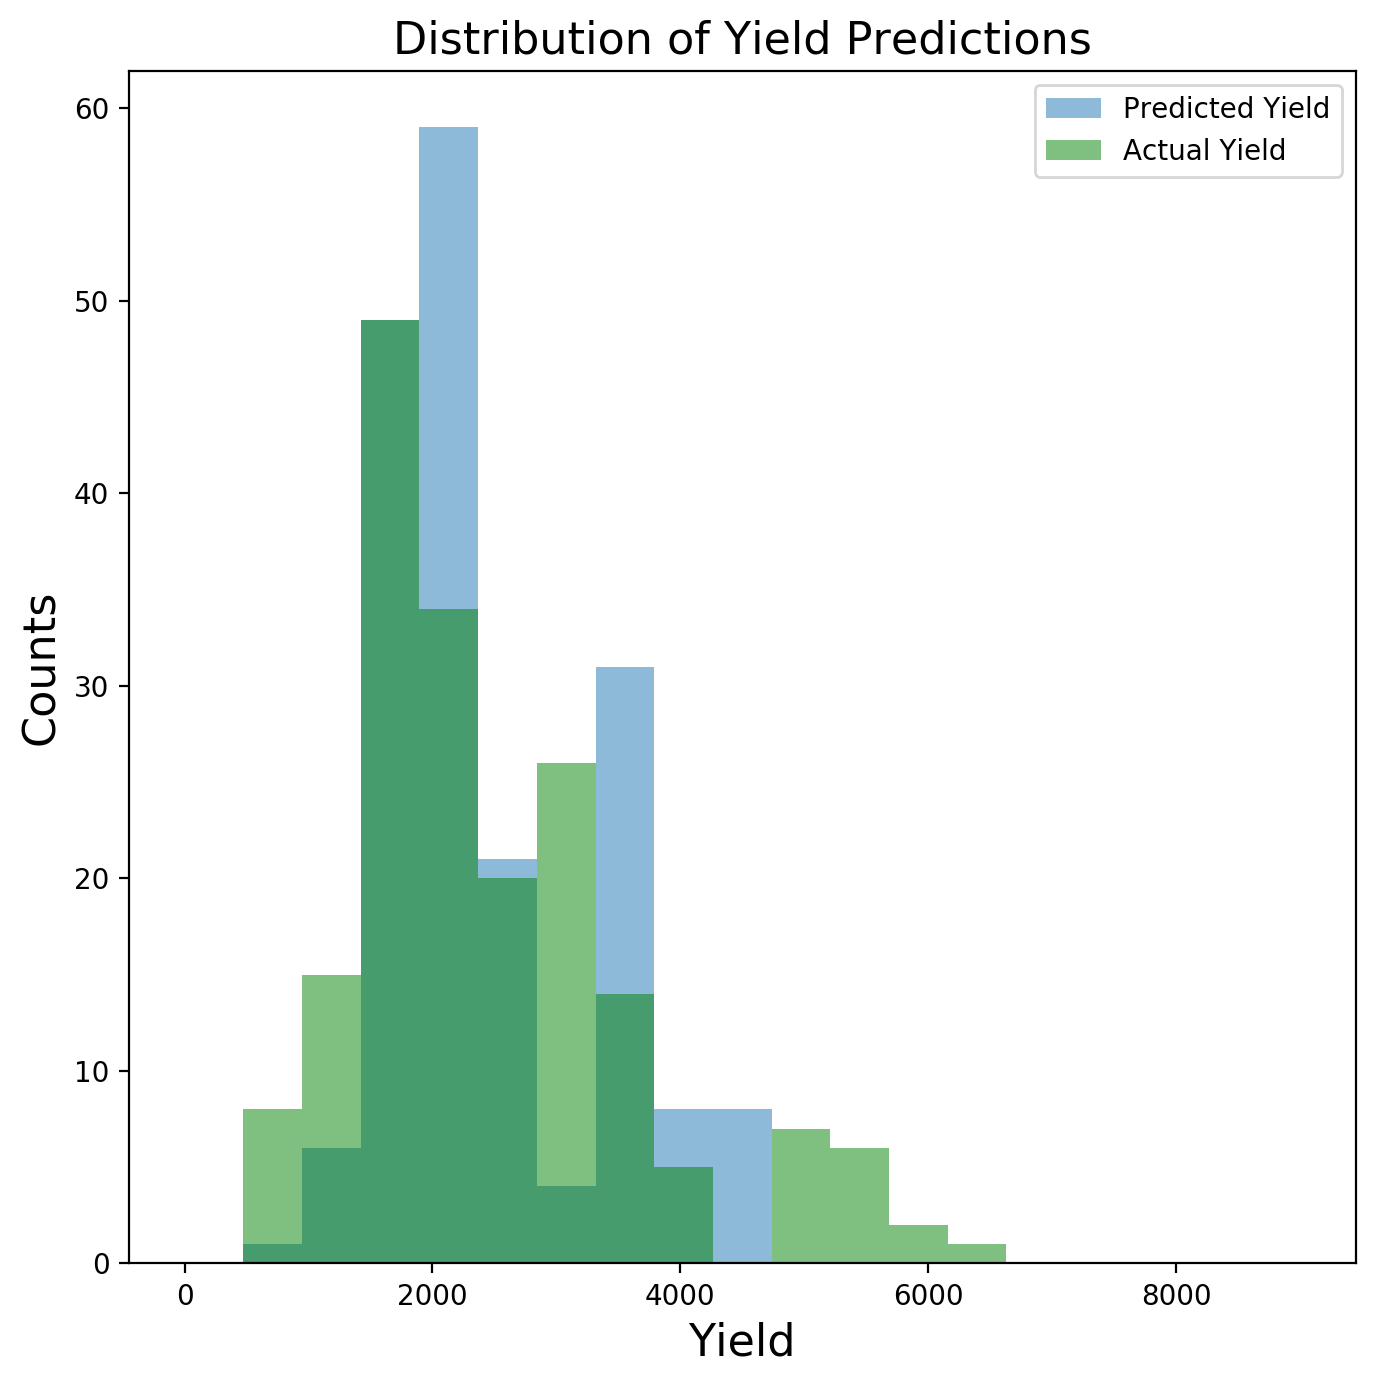

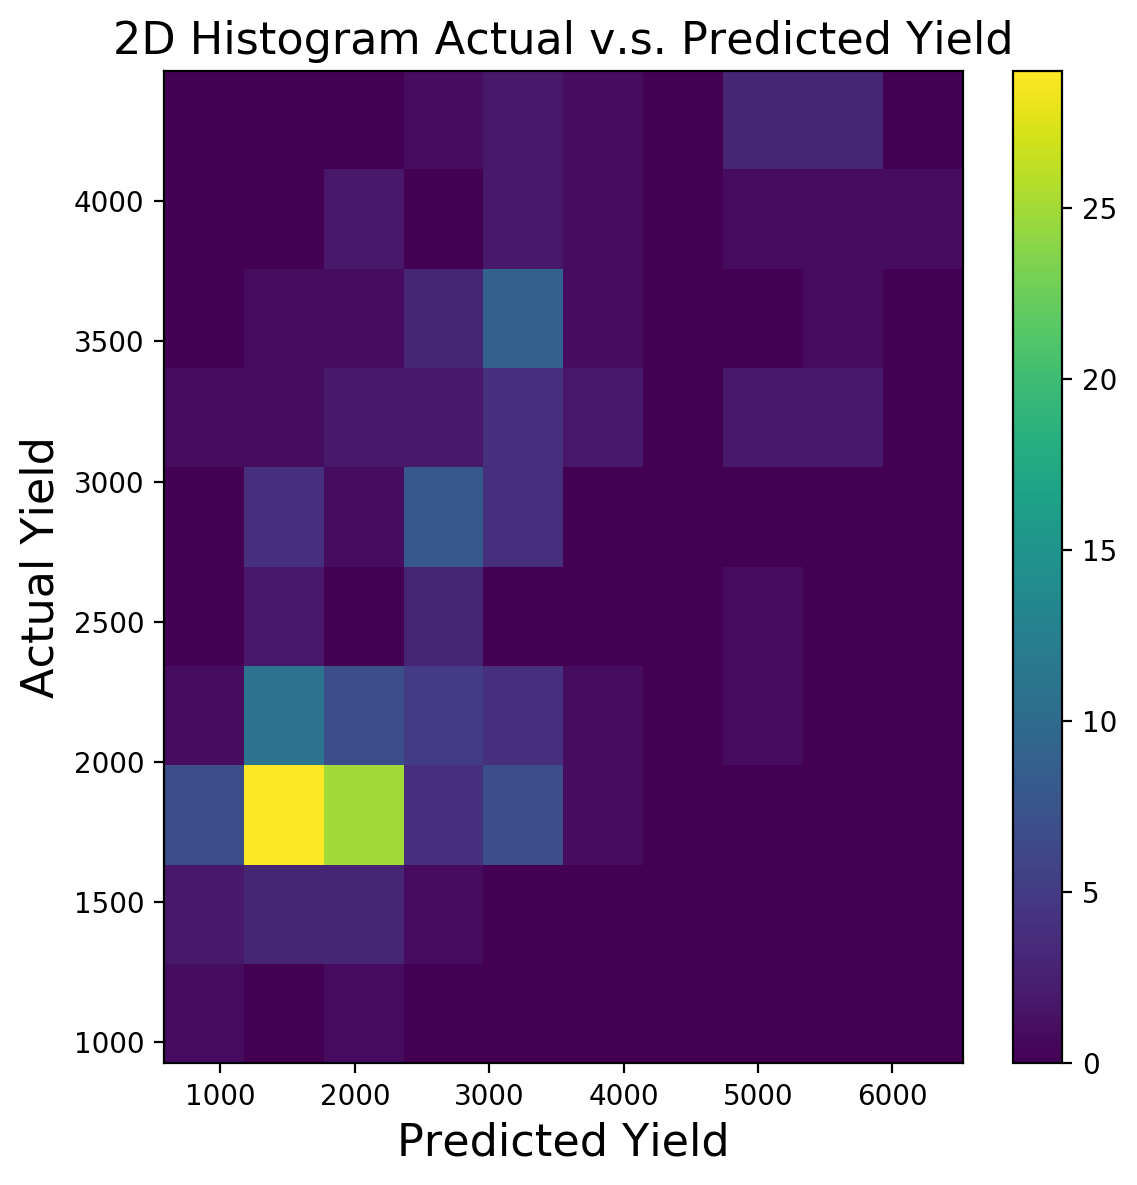

In [378]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')
actual_v_predictions_plot(actual = Y_train, preds=ypred, title = "1D_CNN: Unmask Tiff Yield training data ONLY", metric = None, ci = 80, pos3=None, color='orange',label_dummies=crop_label_train, save=True, savename = "1dcnn_Train")
predicted_actual_dist(Y_train, ypred.flatten(), bins = 20, save = True)
histogram2d(Y_train, ypred)

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Train         72
Validation    24
Name: split, dtype: int64


C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [380]:
## Main crop group
df_canola = df1[df1.crop_2017 == 28.0]
df_canola = train_test_split(df_canola, valsize = 0.25, random_state = 10)

x_canola = scaled_x[df1.crop_2017 == 28.0] 

28.0     96
47.0     67
80.0     63
173.0    24
Name: crop_2017, dtype: int64